In [1]:
# Section 1
import numpy as np
import matplotlib.pyplot as plt
import h5py
import copy

# Section 2
from scipy import signal

# 1. Loading the data #

Load and preprocess the data: copied from notebook 4 of exercises from week 10

In [9]:
# data_path = ''
fs = 24400 # Hz

# Subjects
n_subjects = 2
subjs_info_loading = {'Subject2' : {'Name' : 'p2-t2', 'Vars' : ['Baseline', 'Angio36', 'RR15', 'TV500']},
                      'Subject21' : {'Name' : 'p6-t6', 'Vars' : ['Baseline', 'Angio36', 'RR15', 'TV125']}
                     }
subjs_info_final = {'Subject2' : {'Name' : 'p2-t2', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']},
                    'Subject21' : {'Name' : 'p6-t6', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']}
                   }
animals_labels = ['p2-t2', 'p6-t6']

def load_data_all_subjects(subjs_info_loading, subjs_info_final, fs, type_data = 'Field_Data_Neuro'):
    subjects_names = list(subjs_info_loading.keys())
    subjs_info = subjs_info_final
    all_data = {}
    print('Start loading ... \n')
    for subject in subjects_names:
        name_subj, data_struct = load_data_one_subject(subject, subjs_info_loading, fs, type_data = type_data)
        all_data[name_subj] = data_struct
        print('================== %s loaded. =================='%subject)
    return all_data


def load_data_one_subject(subject, subjs_info_loading, fs, type_data = 'Field_Data_Neuro'):
    name_subj_to_stock = subjs_info_loading[subject]['Name']
    vars_to_load = subjs_info_loading[subject]['Vars']
    data_struct = {}
    
    # file = h5py.File('data\\' + subject + '.mat','r')
    file = h5py.File(subject + '.mat','r')
    
    # To get the names of the fields after decoding ASCII
    all_field_names = get_field_names(file)

    for var in vars_to_load:
        id_field = np.where(all_field_names == var)[0]
        curr_reference_data1 = file['Vagus_Data_Stimuli'][type_data][id_field][0][0]
        curr_reference_data2 = file[curr_reference_data1][0][0]
        final_data = np.transpose(np.asarray(file[curr_reference_data2]))
        
        if var == 'TV800' or var == 'TV500' or var == 'TV125': 
            var_name = 'TVC'
        elif var == 'RR15' or var == 'RR20': 
            var_name = 'RRC'
        else:
            var_name = var
            
        data_struct[var_name] = {}
        data_struct[var_name]['Data'] = final_data
        n_time_pts = np.shape(final_data)[-1]
        data_struct[var_name]['Time_pts'] = np.linspace(0, n_time_pts/fs, n_time_pts)
        
    return name_subj_to_stock, data_struct

def get_field_names(file):
    n_fields,_ = np.shape(file['Vagus_Data_Stimuli']['stimuli_name'])
    all_field_names = []
    for field in range(n_fields):
        curr_reference_field = file['Vagus_Data_Stimuli']['stimuli_name'][field][0]
        curr_field_ASCII = file[curr_reference_field]
        curr_field = decode_ASCII(curr_field_ASCII)
        all_field_names.append(curr_field)
    return np.asarray(all_field_names)


def decode_ASCII(numbers_array):
    name = ''
    squeezed_numbers = np.squeeze(numbers_array)
    for n in squeezed_numbers:
        name += chr(n)
    return name

data = load_data_all_subjects(subjs_info_loading, subjs_info_final, fs)
print('Loading completed \n')

#print('Showing the data file:')
#for key1 in data.keys():
#    print('=========== %s ==========='%key1)
#    for key2 in data[key1].keys():
#        print('--- %s'%key2)
#        for key3 in data[key1][key2].keys():
#            print(' - %s'%key3)
#            print('Shape : ', np.shape(data[key1][key2][key3]))

def cut_all_data_to_established_duration_per_challenge(data):
    '''
    This function is a wrap-up to the function 'cut_data_one_pig_to_established_duration_per_challenge'.
    '''
    
    new_data_struct = {}
    for pig in data.keys():
        print('================== Working on Pig %s =================='%pig)
        data_curr_pig = data[pig]
        data_curr_pig_cut = cut_data_one_pig_to_established_duration_per_challenge(data_curr_pig)
        new_data_struct[pig] = data_curr_pig_cut
        
    return new_data_struct


def cut_data_one_pig_to_established_duration_per_challenge(data_one_pig):
    ''' 
    This function is used to cut the data for each challenge to the duration shown in Suppl. Table 1 in Vallone et al., 2021. 
    We take the first part of the data for each challenge (arbitrary choice). 
    '''
    new_struct = copy.deepcopy(data_one_pig)
    
    dur_baseline = 5 #min
    dur_RRC = 2 #min
    dur_TVC = 2 #min
    
    for challenge in new_struct.keys():
        data_curr_chal = new_struct[challenge]['Data']
        time_pts_curr_chal = new_struct[challenge]['Time_pts']
        t_end_sec = time_pts_curr_chal[-1]
        
        if challenge == 'Baseline': t_end_sec = dur_baseline * 60
        elif challenge == 'RRC': t_end_sec = dur_RRC * 60
        elif challenge == 'TVC': t_end_sec = dur_TVC * 60
            
#         print('Challenge %s , t_end_sec %0.3f'%(challenge, t_end_sec))
            
        id_t_end_curr_chal = find_specific_time_index(time_pts_curr_chal, t_end_sec)
        new_struct[challenge]['Data'] = data_curr_chal[:,:id_t_end_curr_chal]
        new_struct[challenge]['Time_pts'] = time_pts_curr_chal[:id_t_end_curr_chal]
    
    return new_struct

def find_specific_time_index(time_pts, t):
    t_id = np.argmin(np.abs(time_pts - t))
    return t_id

print('Start cutting data ... \n')
cut_data = cut_all_data_to_established_duration_per_challenge(data)
print('Data cutting completed \n')

Start loading ... 

================== Subject2 loaded. ==================
================== Subject21 loaded. ==================
================== Working on Pig p2-t2 ==================
================== Working on Pig p6-t6 ==================


We now now have ...

In [12]:
print('Showing the data files:')
for key1 in cut_data.keys():
    print('=========== %s ==========='%key1)
    for key2 in cut_data[key1].keys():
        print('--- %s'%key2)
        for key3 in cut_data[key1][key2].keys():
            print(' - %s'%key3)
            print('Shape : ', np.shape(cut_data[key1][key2][key3]), ', type: ', type(cut_data[key1][key2][key3]))

Showing the data files:
=========== p2-t2 ===========
--- Baseline
 - Data
Shape :  (8, 7319999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (7319999,) , type:  <class 'numpy.ndarray'>
--- Angio36
 - Data
Shape :  (8, 14780415) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (14780415,) , type:  <class 'numpy.ndarray'>
--- RRC
 - Data
Shape :  (8, 2927999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (2927999,) , type:  <class 'numpy.ndarray'>
--- TVC
 - Data
Shape :  (8, 2927999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (2927999,) , type:  <class 'numpy.ndarray'>
=========== p6-t6 ===========
--- Baseline
 - Data
Shape :  (16, 7319999) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (7319999,) , type:  <class 'numpy.ndarray'>
--- Angio36
 - Data
Shape :  (16, 14940159) , type:  <class 'numpy.ndarray'>
 - Time_pts
Shape :  (14940159,) , type:  <class 'numpy.ndarray'>
--- RRC
 - Data
Shape :  (16, 2927999) , type:  <class 'numpy.ndarray'>
 - T

# 2. Preprocessing #

Get an understanding of the data:

In [44]:
t = cut_data['p2-t2']['Baseline']['Time_pts']
neur = cut_data['p2-t2']['Baseline']['Data']

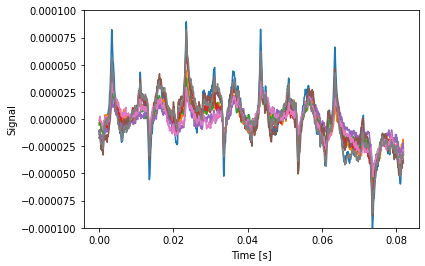

In [57]:
for i in range(0, neur.shape[0]):
    plt.plot(t[:2000], neur[i,:2000])
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.ylim(-0.0001, 0.0001)
plt.show()

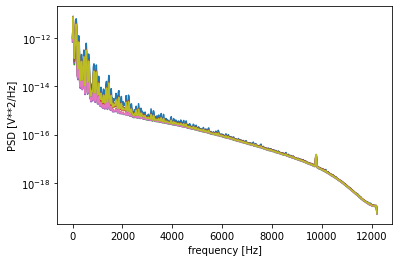

In [43]:

# fs = 1/(t[1]-t[0]) computed above

for i in range(0, neur.shape[0]):
    (f, S)= signal.welch(neur[i,:], fs, nperseg=1024)
    plt.semilogy(f, S)
plt.semilogy(f, S)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [42]:
print(2*fs)

48800


The paper says they use a 4-order Butterworth filter [1000, 6000] Hz. 

Note that we have fs= 24400Hz, hence by Shannon the recorded signal can have no components above 2*fs 4800. For this reason, any data above 5k Hz is spurious. 

We highpass at 1kHz to remove any forms of noise, notably due to the organism itself. 

In [67]:
f_low = 1000 # [Hz]
f_high = 6000 # [Hz]
N = 4 # order of the filter
sos = signal.butter(N, [f_low, f_high], 'bandpass', analog=False, fs=fs, output='sos')

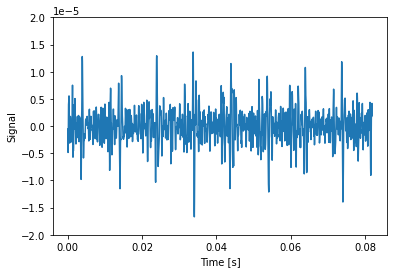

In [86]:
#for i in range(0, neur.shape[0]):
for i in range(1): 
    data_filtered = signal.sosfilt(sos, neur[0,:])
    plt.plot(t[:2000], data_filtered[:2000])
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.ylim(-0.00002, 0.00002)
plt.show()

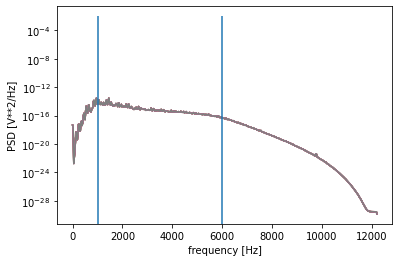

In [83]:
for i in range(0, neur.shape[0]):
    dat= signal.sosfilt(sos, neur[0,:])
    (f, S)= signal.welch(dat, fs, nperseg=1024)
    plt.semilogy(f, S)
plt.vlines(1000, 0.01, -0.01)
plt.vlines(6000, 0.01, -0.01)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Now that we know it works, run it on the entire signal:

In [121]:
data_blank = {'p2-t2': 
                {'Baseline': {'Data': {}, 'Time_pts': {}},
                'Angio36': {'Data': {}, 'Time_pts': {}},
                'RRC': {'Data': {}, 'Time_pts': {}},
                'TVC': {'Data': {}, 'Time_pts': {}}
                    },
                'p6-t6':
                {'Baseline': {'Data': {}, 'Time_pts': {}},
                'Angio36': {'Data': {}, 'Time_pts': {}},
                'RRC': {'Data': {}, 'Time_pts': {}},
                'TVC': {'Data': {}, 'Time_pts': {}}
                    } 
                }

In [ ]:
data_blank = {'p2-t2': 
                {'Baseline': {'Data': {}, 'Time_pts': {}},
                'Angio36': {'Data': {}, 'Time_pts': {}},
                'RRC': {'Data': {}, 'Time_pts': {}},
                'TVC': {'Data': {}, 'Time_pts': {}}
                    },
                'p6-t6':
                {'Baseline': {'Data': {}, 'Time_pts': {}},
                'Angio36': {'Data': {}, 'Time_pts': {}},
                'RRC': {'Data': {}, 'Time_pts': {}},
                'TVC': {'Data': {}, 'Time_pts': {}}
                    } 
                }

In [122]:
def bandpass_data(data, sos):
    print('Bandpassing the data... \n')
    # new_data_struct = copy.deepcopy(data)
    new_data_struct = data_blank
    for pig in data.keys():
        print('=========== %s ==========='%pig)
        for challenge in data[pig].keys():
            new_data_struct[pig][challenge]['Data'] = signal.sosfilt(sos, cut_data[pig][challenge]['Data'])
    return new_data_struct        

In [123]:
# takes ~40sec to run
data_filtered = bandpass_data(cut_data, sos)

Bandpassing the data... 

=========== p2-t2 ===========
=========== p6-t6 ===========


Sub-sampling of the signal by a factor 2:

In [124]:
data_filtered['p2-t2']['Baseline']['Data'].shape

(8, 7319999)

In [126]:
# takes ~20sec to run
# data_subsampled = copy.deepcopy(data_filtered)
data_subsampled = data_blank
for pig in data.keys():
    for challenge in data[pig].keys():
        data_subsampled[pig][challenge]['Data'] = data_subsampled[pig][challenge]['Data'][:,0:-1:2]

In [127]:
data_subsampled['p2-t2']['Baseline']['Data'].shape

(8, 3659999)

# 3. split + Windowing #

Use a test-train split of 10-90, as given in the report. 

Note that in reality, points will necessarily be temporally correlated. To better simulate reality, we ensure that points in the training set and points in the testing set are congruent in time. 

In [128]:
def split_data(data, tt_split):
    #data_train = copy.deepcopy(data_filtered)
    #data_test = copy.deepcopy(data_filtered)
    data_train = data_blank
    data_test = data_blank
    for pig in data_subsampled.keys():
        for challenge in data_subsampled[pig].keys():
            L = data[pig][challenge]['Data'].shape[1]
            data_train[pig][challenge]['Data'] = data[pig][challenge]['Data'][:,0:int(tt_split*L)]
            data_test[pig][challenge]['Data'] = data[pig][challenge]['Data'][:,int(tt_split*L):]
    return data_train, data_test

In [129]:
tt_split = 0.9
data_train, data_test = split_data(data_subsampled, tt_split)

In [ ]:
print(data_train[][][])

Perform windowing to extract points:

In [117]:
# Extract the features into num_windows concatenated arrays of length 8 channels x 9 features.
def extract_features(window, windowSize):
    features = []
    for channel in np.reshape(window, (8, windowSize)):
        mean = ...
        variance = ...
        skew = ...
        kurtosis = ...
        mav = ...
        max = ...
        amp = ...
        wh = ...
        pow = ...
        features.extend([mean, variance, skew, kurtosis, mav, max, amp, wh, pow])
        features = np.array(features)
    return features

# Expand the dataset by taking a sliding window of length win_size with 20% overlap in train and 0% overlap in test.
# Returns num_window arrays of features and corresponding class label
def make_windows_and_features(data, windowSize_t, windowOverlap, fs):
    windowSize_n = fs * win_size # goes from window size in time to number of samples
    step = int(windowSize_n * windowOverlap)
    features = []
    for i in range(0, len(data)-windowSize_n, step):
        x = data[:,i:i+windowSize_n]
        features.append(extract_features(np.array(x), windowSize_n))
    features = np.array(features)
    return features

# current structure: {pig:{class:{data:[]}}}

In [120]:
dict_blank = {'Subject2' : {'Name' : 'p2-t2', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']},
                    'Subject21' : {'Name' : 'p6-t6', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']}
                   }

data_blank = {'p2-t2': 
                {'Baseline': {'Data': {}, 'Time_pts': {}},
                'Angio36': {'Data': {}, 'Time_pts': {}},
                'RRC': {'Data': {}, 'Time_pts': {}},
                'TVC': {'Data': {}, 'Time_pts': {}}
                    },
                'p6-t6':
                {'Baseline': {'Data': {}, 'Time_pts': {}},
                'Angio36': {'Data': {}, 'Time_pts': {}},
                'RRC': {'Data': {}, 'Time_pts': {}},
                'TVC': {'Data': {}, 'Time_pts': {}}
                    } 
                }

print(data_blank['p2-t2']['Baseline']['Data'])

{}


In [ ]:
dict_blank = {'Subject2' : {'Name' : 'p2-t2', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']},
                    'Subject21' : {'Name' : 'p6-t6', 'Vars' : ['Baseline', 'Angio36', 'RRC', 'TVC']}
                   }

def apply_windowing_and_features(data):
    data = dict_blank
    for 